**COVID Jobs Paper**

By:
1. Ashutosh Agrahari
2. Ankur Veer
3. Pawan Singh
4. Anshuman Singh


1. Make two data - 1) 1991-2019 and 2) 1991- Jul 2020
2. Train model on two data. Let trained models be M1 and M2.
3. Make a dataframe with one column 'ds' with values from Jun 2019 to Jul 2020.
4. Generate predictions from the two trained models on this dataframe. Let them be P1 and P2.
5. The actual values for Jun 2019 to Jul 2020 are with us. Let it be C.
6. Combine the preds of two models as, 
    aP1 + bP2
7. Minimize the difference between actual and predicted values.
8. Minimize the expression, aP1 + bP2 - C, and find values of a and b using least squares approximation.
9. Use the calculated a and b to combine predictions on further timelines, from Aug 2020 onwards.


---



In [1]:
import pandas as pd
import datetime
from fbprophet import Prophet
import os
os.chdir('/content/drive/MyDrive/COVID_Jobs')

In [2]:
# Make future dataframe
"""
fd = ['30-06-2019','31-07-2019','31-08-2019','30-09-2019','31-10-2019',\
  '30-11-2019','31-12-2019','31-01-2020','29-02-2020','31-03-2020','30-04-2020',\
    '31-05-2020','30-06-2020','31-07-2020','31-08-2020','30-09-2020','31-10-2020','30-11-2020']
"""


"\nfd = ['30-06-2019','31-07-2019','31-08-2019','30-09-2019','31-10-2019',  '30-11-2019','31-12-2019','31-01-2020','29-02-2020','31-03-2020','30-04-2020',    '31-05-2020','30-06-2020','31-07-2020','31-08-2020','30-09-2020','31-10-2020','30-11-2020']\n"

**Model 2** without COVID pattern

In [3]:
### Model 2
new_df2 = pd.read_csv('Data/Monthly_Unemployment_1991-2020.csv')
new_df2['ds'] = pd.to_datetime(new_df2['ds'], yearfirst=True)

# Train M2
m2 = Prophet(seasonality_mode='additive')
m2.fit(new_df2)

future = m2.make_future_dataframe(periods=0, freq='M')

# Preds 2
P2 = m2.predict(future)[['ds', 'yhat']]


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [4]:
future

,ds
0,1991-12-31
1,1992-01-31
2,1992-02-29
3,1992-03-31
4,1992-04-30
...,...
343,2020-07-31
344,2020-08-31
345,2020-09-30
346,2020-10-31


**Model 1** with COVID pattern

In [5]:
### Model 1
d1 = pd.read_excel('Data/Unemployment_Rate_India_1991-2019.xlsx')
df1 = d1.rename(columns = {"Year": "ds", "Unemployment Rate":"y"})
df1['ds'] = pd.to_datetime(df1['ds'], yearfirst=True)

# interpolate data to get it for months
new_df1 = df1.set_index('ds').resample('M').interpolate(method='linear', axis=0, limit=None, inplace=False,\
         limit_direction='forward', limit_area=None, downcast=None).reset_index()

# Train M1
m1 = Prophet(seasonality_mode='multiplicative')
m1.fit(new_df1)

# Preds 1
P1 = m1.predict(future)[['ds', 'yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
p, q = new_df1.shape[0], new_df2.shape[0]
p_ratio = p/(p+q)
q_ratio = q/(p + q)
p_ratio, q_ratio

(0.491970802919708, 0.5080291970802919)

In [7]:
### Original Values (C)
C = new_df2['y']

In [8]:
# Import modules
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Least Squares Approximation**

to estimate a and b, so as to combine results from models trained on both patterns.

In [9]:
## Now implementing Least Squares Approximation
from scipy.optimize import leastsq

xdata = np.transpose(np.array([P1['yhat'],P2['yhat']]))
ydata = np.transpose(np.array(C))

In [10]:
def func(params, xdata, ydata):
    return (ydata - np.dot(xdata, params))

In [11]:
params = leastsq(func, [0,0], args=(xdata, ydata))
a, b = params[0]
a_, b_ = a*p_ratio, b*q_ratio
a_1, b_1 = a*q_ratio, b*p_ratio
params1, params2, params3 = (a, b) , (a_, b_), (a_1, b_1)
params1, params2, params3

((-0.11130116629378912, 1.1055010136369792),
 (-0.05475692414745538, 0.5616267923294433),
 (-0.05654424214633374, 0.5438742213075357))

so now **a = -13.344894120968593** and **b = 10.07420211311749**, as calculated using least squares approximation

Now we can use equation, aP1 + bP2 to combine predictions from both models.


---



---



In [12]:
# Combined Predictions as per LSA and params1
res = np.dot(xdata, params1)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds1 = pd.concat([future, res_df], axis=1)
LSA_preds1

,ds,yhat
0,1991-12-31,5.330541
1,1992-01-31,5.688630
2,1992-02-29,5.426846
3,1992-03-31,5.318257
4,1992-04-30,6.440369
...,...,...
343,2020-07-31,7.765284
344,2020-08-31,8.160171
345,2020-09-30,8.177875
346,2020-10-31,8.223710


In [13]:
# Combined Predictions as per LSA and params2
res = np.dot(xdata, params2)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds2 = pd.concat([future, res_df], axis=1)
LSA_preds2

,ds,yhat
0,1991-12-31,2.717809
1,1992-01-31,2.899733
2,1992-02-29,2.766749
3,1992-03-31,2.711588
4,1992-04-30,3.281660
...,...,...
343,2020-07-31,3.954406
344,2020-08-31,4.155012
345,2020-09-30,4.163998
346,2020-10-31,4.187275


In [14]:
# Combined Predictions as per LSA and params2
res = np.dot(xdata, params3)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds3 = pd.concat([future, res_df], axis=1)
LSA_preds3

,ds,yhat
0,1991-12-31,2.612732
1,1992-01-31,2.788897
2,1992-02-29,2.660097
3,1992-03-31,2.606668
4,1992-04-30,3.158709
...,...,...
343,2020-07-31,3.810878
344,2020-08-31,4.005159
345,2020-09-30,4.013877
346,2020-10-31,4.036435


In [15]:
dfC = pd.DataFrame(ydata, columns=['Actuals'])
comp_Res1 = pd.concat([LSA_preds1, dfC], axis=1)
comp_Res2 = pd.concat([LSA_preds2, dfC], axis=1)
comp_Res3 = pd.concat([LSA_preds3, dfC], axis=1)

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params1')

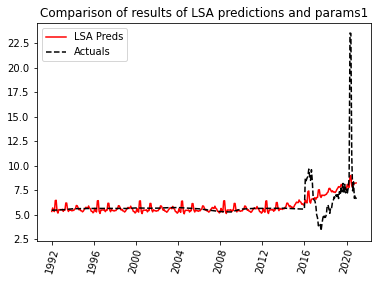

In [16]:
plt.plot(comp_Res1['ds'], comp_Res1['yhat'], '-r')
plt.plot(comp_Res1['ds'], comp_Res1['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params1')

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params2')

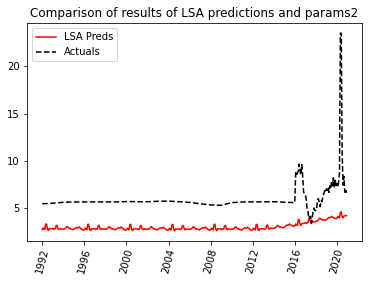

In [17]:
plt.plot(comp_Res2['ds'], comp_Res2['yhat'], '-r')
plt.plot(comp_Res2['ds'], comp_Res2['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params2')

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params3')

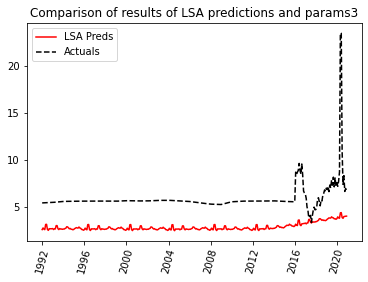

In [18]:
plt.plot(comp_Res3['ds'], comp_Res3['yhat'], '-r')
plt.plot(comp_Res3['ds'], comp_Res3['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params3')

**Predicting on future timelines**


---



Text(0.5, 1.0, "Predictions for next 13 months from Dec'20 v1")

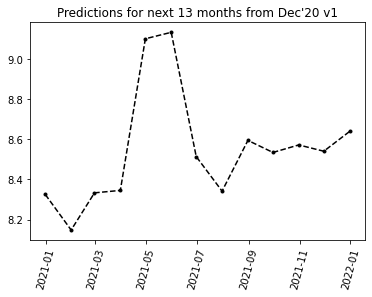

In [19]:
# Make future dataframe
n_mths = 13
future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params1)
final_preds1 = pd.DataFrame(res, columns=['yhat'])
final_preds1 = pd.concat([future_timeline, final_preds1], axis=1)
print(final_preds1)

plt.plot(final_preds1['ds'], final_preds1['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v1'%(n_mths))

           ds      yhat
0  2020-12-31  4.238638
1  2021-01-31  4.148815
2  2021-02-28  4.242774
3  2021-03-31  4.248942
4  2021-04-30  4.632475
5  2021-05-31  4.648727
6  2021-06-30  4.334426
7  2021-07-31  4.247103
8  2021-08-31  4.375362
9  2021-09-30  4.344875
10 2021-10-31  4.363874
11 2021-11-30  4.347955
12 2021-12-31  4.398026


Text(0.5, 1.0, "Predictions for next 13 months from Dec'20 v2")

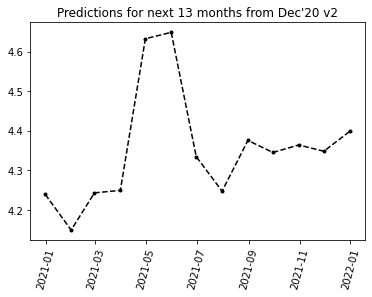

In [20]:
# Make future dataframe
n_mths = 13
future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params2)
final_preds2 = pd.DataFrame(res, columns=['yhat'])
final_preds2 = pd.concat([future_timeline, final_preds2], axis=1)
print(final_preds2)

plt.plot(final_preds2['ds'], final_preds2['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v2'%(n_mths))

           ds      yhat
0  2020-12-31  4.086212
1  2021-01-31  3.999250
2  2021-02-28  4.090251
3  2021-03-31  4.096246
4  2021-04-30  4.467678
5  2021-05-31  4.483437
6  2021-06-30  4.179089
7  2021-07-31  4.094544
8  2021-08-31  4.218766
9  2021-09-30  4.189260
10 2021-10-31  4.207674
11 2021-11-30  4.192274
12 2021-12-31  4.240778


Text(0.5, 1.0, "Predictions for next 13 months from Dec'20 v3")

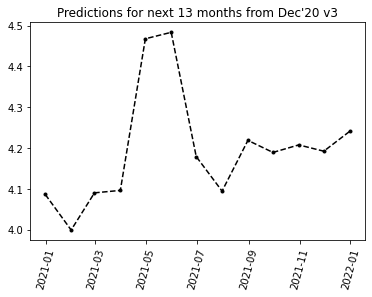

In [21]:
# Make future dataframe
n_mths = 13
future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params3)
final_preds3 = pd.DataFrame(res, columns=['yhat'])
final_preds3 = pd.concat([future_timeline, final_preds3], axis=1)
print(final_preds3)

plt.plot(final_preds3['ds'], final_preds3['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v3'%(n_mths))
